In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/Cape_Trackman_Combined_July7.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

def categorize_os(dfgy):
    # Replace 'slider' with 'sweeper' or 'gyro' based on horizontal break values
    dft.loc[(dft['Pitch Type'] == 'Slider') & (dft['Horizontal Break'] > 14), 'Pitch Type'] = 'Sweeper'
    dft.loc[dft['Pitch Type'] == 'Slider', 'Pitch Type'] = 'Gyro'
    
    
    return dft

# Call the function to categorize sliders in the dataframe
dft = categorize_os(dft)

# Create a new dataframe with only pitches that are Four-Seam FB from RHP
dfgy = dfgy[(dfgy['Pitch Type'] == 'Gyro')]

# Handle NA values
dfgy.fillna(dfgy.mean(), inplace=True)

dfgy['Release Side^3'] = pow(dfgy['Release Side'], 3)
dfgy['Velocity Pow'] = pow(dfgy['Velocity'], 3) + pow(dfgy['Velocity'], 2)
dfgy['Extension^3'] = pow(dfgy['Extension'], 3)
dfgy['IVB^2'] = pow(dfgy['Induced Vertical Break'], 2)
dfgy['DFBR^3'] = pow(dfgy['Differential Break'], 3)

# Filter to only include swings
dfgy_swing = dfgy[(dfgy['Swing'] == 1)]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-3ace7478df8a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-3ace7478df8a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [3]:
dfbr.head()

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Hit Type,KorBB,Differential Break,Whiff,Swing,Release Side^3,Velocity Pow,Extension^3,IVB^2,DFBR^3
27,Ryan Fischer,Gyro,BallCalled,BOU_BRA,Trevor Austin,BRE_WHI,Right,81.26923,2223.080050,5.26915,...,Undefined,Undefined,5.54185,0,0,6.729859,543362.575155,196.692620,13.141495,170.201859
28,Ryan Fischer,Gyro,StrikeCalled,BOU_BRA,Trevor Austin,BRE_WHI,Right,81.38558,2447.802937,5.35992,...,Undefined,Undefined,7.70118,0,0,5.880051,545690.168377,199.156241,16.352157,456.742919
30,Ryan Fischer,Gyro,BallCalled,BOU_BRA,Trevor Austin,BRE_WHI,Right,82.58390,2458.778885,5.30627,...,Undefined,Undefined,6.19528,0,0,7.360708,570050.601459,212.153422,28.977873,237.784104
39,Ryan Fischer,Gyro,InPlay,BOU_BRA,Ajay Szcepkowski,BRE_WHI,Right,81.85850,2230.462370,5.36219,...,LineDrive,Undefined,4.67863,0,1,6.305069,555219.398663,203.916289,19.622508,102.413239
40,Ryan Fischer,Gyro,BallCalled,BOU_BRA,Jaime Ferrer,BRE_WHI,Right,80.18122,2194.051447,5.33575,...,Undefined,Undefined,2.18126,0,0,5.917268,521916.339757,224.671439,5.763985,10.378206


In [4]:
dfbr.columns

Index(['Pitcher', 'Pitch Type', 'Pitch Result', 'Pitcher Team', 'Batter',
       'Batter Team', 'P Side', 'Velocity', 'Spin Rate', 'Release Height',
       'Pitch Height', 'Pitch Side', 'Release Side', 'Extension',
       'Induced Vertical Break', 'Horizontal Break', 'Pitch Call',
       'Play Result', 'Hit Type', 'KorBB', 'Differential Break', 'Whiff',
       'Swing', 'Release Side^3', 'Velocity Pow', 'Extension^3', 'IVB^2',
       'DFBR^3'],
      dtype='object')

In [5]:
# Linear regression Model

#X = dfbr_swing[['Spin Rate^2', 'Horizontal Break Pow', 'Extension^2', 'Velocity^2', 'Release Height']]
X = dfbr_swing[['Velocity Pow', 'Spin Rate', 'Release Height', 'Release Side^3', 'Extension^3', 'IVB^2', 'Horizontal Break', 'DFBR^3']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.25120441743765964
Linear Regression R-squared score: -0.010285810100356008


In [6]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                  importance
Velocity Pow        0.079454
IVB^2               0.028801
DFBR^3              0.018213
Horizontal Break    0.007617
Spin Rate          -0.001634
Release Side^3     -0.008558
Extension^3        -0.010663
Release Height     -0.027627


In [7]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.26017135249995715
Random Forest R-squared score: -0.04634873982880605


In [8]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                  importance
Velocity Pow        0.153156
Extension^3         0.126384
Release Height      0.123986
Release Side^3      0.123120
IVB^2               0.120518
DFBR^3              0.120402
Spin Rate           0.117768
Horizontal Break    0.114666


In [9]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.28340114547204037
XGBoost R-squared score: -0.13977357069225516


In [10]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                  importance
DFBR^3              0.146558
IVB^2               0.143906
Extension^3         0.138795
Horizontal Break    0.131854
Release Side^3      0.127574
Release Height      0.112808
Spin Rate           0.105442
Velocity Pow        0.093064


In [11]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.3018277721115842
R-squared score: -0.21388118238092413


In [12]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

12/12 [==============================] - 0s 1ms/step
Mean Squared Error: 0.3287429367244321
R-squared score: -0.3221277218416547


In [13]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

12/12 [==============================] - 0s 2ms/step


In [14]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

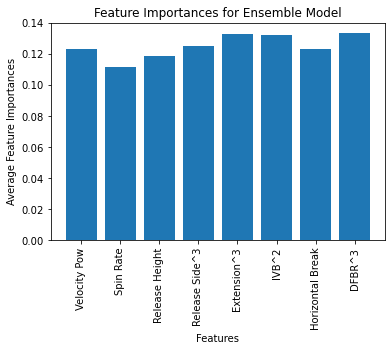

In [15]:
features_list = ['Velocity Pow', 'Spin Rate', 'Release Height', 'Release Side^3', 'Extension^3', 'IVB^2', 'Horizontal Break', 'DFBR^3']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [16]:
X = dfgy[['Velocity Pow', 'Spin Rate', 'Release Height', 'Release Side^3', 'Extension^3', 'IVB^2', 'Horizontal Break', 'DFBR^3']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfgy['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

162/162 [==============================] - 0s 1ms/step


In [18]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

41/41 [==============================] - 0s 2ms/step


In [19]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

In [20]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

In [21]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [22]:
# Calculate the 'Stuff+' values
dfgy['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

<ipython-input-22-b5695bafb0d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbr['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [25]:
dfgy = dfgy.round(2)

In [26]:
dfgy['Stuff+'].describe()

count    6469.000000
mean      100.000182
std        23.958708
min        21.980000
25%        85.040000
50%        96.830000
75%       114.400000
max       244.290000
Name: Stuff+, dtype: float64

In [27]:
dfgy.head(30)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,KorBB,Differential Break,Whiff,Swing,Release Side^3,Velocity Pow,Extension^3,IVB^2,DFBR^3,Stuff+
27,Ryan Fischer,Gyro,BallCalled,BOU_BRA,Trevor Austin,BRE_WHI,Right,81.27,2223.08,5.27,...,Undefined,5.54,0,0,6.73,543362.58,196.69,13.14,170.20,91.65
28,Ryan Fischer,Gyro,StrikeCalled,BOU_BRA,Trevor Austin,BRE_WHI,Right,81.39,2447.80,5.36,...,Undefined,7.70,0,0,5.88,545690.17,199.16,16.35,456.74,103.29
30,Ryan Fischer,Gyro,BallCalled,BOU_BRA,Trevor Austin,BRE_WHI,Right,82.58,2458.78,5.31,...,Undefined,6.20,0,0,7.36,570050.60,212.15,28.98,237.78,113.36
39,Ryan Fischer,Gyro,InPlay,BOU_BRA,Ajay Szcepkowski,BRE_WHI,Right,81.86,2230.46,5.36,...,Undefined,4.68,0,1,6.31,555219.40,203.92,19.62,102.41,85.15
40,Ryan Fischer,Gyro,BallCalled,BOU_BRA,Jaime Ferrer,BRE_WHI,Right,80.18,2194.05,5.34,...,Undefined,2.18,0,0,5.92,521916.34,224.67,5.76,10.38,89.34
61,Ryan Fischer,Gyro,InPlay,BOU_BRA,Dylan Leach,BRE_WHI,Right,79.15,2410.14,5.44,...,Undefined,9.72,0,1,8.84,502069.75,185.04,16.16,918.30,67.85
64,Ryan Fischer,Gyro,FoulBall,BOU_BRA,Joe Stella,BRE_WHI,Right,81.55,2273.77,5.31,...,Undefined,4.87,0,0,5.27,549076.22,219.87,16.58,115.54,94.67
65,Ryan Fischer,Gyro,FoulBall,BOU_BRA,Joe Stella,BRE_WHI,Right,80.55,2302.67,5.31,...,Undefined,2.70,0,0,6.71,529148.74,203.30,14.26,19.59,86.21
66,Ryan Fischer,Gyro,BallinDirt,BOU_BRA,Joe Stella,BRE_WHI,Right,82.12,2225.82,5.24,...,Undefined,2.95,0,0,5.61,560475.71,203.97,16.47,25.68,93.93
70,Ryan Fischer,Gyro,FoulBall,BOU_BRA,Joe Stella,BRE_WHI,Right,82.10,2320.13,5.34,...,Undefined,1.49,0,0,6.13,560201.05,211.97,2.91,3.33,110.32


In [28]:
# Sort the DataFrame by 'Stuff+' values in descending order
dfgy_sorted = dfgy.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfgy_sorted.reset_index(drop=True, inplace=True)

dfgy_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,KorBB,Differential Break,Whiff,Swing,Release Side^3,Velocity Pow,Extension^3,IVB^2,DFBR^3,Stuff+
0,Aidan Major,Gyro,StrikeSwinging,WAR_GAT,Matt Halbach,ORL_FIR,Right,95.57,2634.15,5.87,...,Undefined,7.77,1,1,6.83,882024.50,141.61,364.27,469.48,244.29
1,Joey DeChiaro,Gyro,StrikeCalled,BRE_WHI,Carter Mathison,COT_KET,Left,85.38,2070.83,5.52,...,Undefined,31.67,0,0,1.61,629734.85,154.82,474.45,31774.89,243.05
2,Liam Doyle,Gyro,FoulBall,BOU_BRA,Elijah Hainline,HYA_HAR,Left,90.86,2085.99,5.65,...,Undefined,29.72,0,0,0.61,758476.37,210.51,349.84,26244.62,243.02
3,Andrew Armstrong,Gyro,BallCalled,HAR_MAR,Kaden Hopson,CHA_ANG,Left,88.27,2106.64,5.15,...,Undefined,30.21,0,0,5.46,695642.17,193.45,330.22,27581.16,238.74
4,Brett Wozniak,Gyro,StrikeCalled,WAR_GAT,Travis Bazzana,FAL_COM,Left,87.31,2322.56,6.07,...,Undefined,26.43,0,0,7.39,673184.33,146.21,322.18,18463.07,229.54
5,Cam Schuelke,Gyro,FoulBall,COT_KET,Dylan Leach,BRE_WHI,Right,70.86,2626.18,2.46,...,Undefined,35.03,0,0,12.30,360888.89,95.80,488.81,42970.22,223.27
6,Liam Paddack,Gyro,BallCalled,CHA_ANG,Cannon Peebles,COT_KET,Left,88.16,2428.70,5.91,...,Undefined,24.52,0,0,3.27,692883.26,260.41,215.75,14740.69,213.13
7,Riley Frey,Gyro,BallCalled,ORL_FIR,Trey Lipsey,HYA_HAR,Left,91.11,2328.94,5.58,...,Undefined,26.59,0,0,18.35,764622.87,271.37,303.95,18804.73,213.00
8,John Modugno,Gyro,FoulBall,BRE_WHI,Kaeden Kent,CHA_ANG,Right,88.39,2446.48,6.39,...,Undefined,19.43,0,0,2.42,698489.63,104.19,140.29,7334.07,207.08
9,Coleman Picard,Gyro,BallCalled,WAR_GAT,Will Pearson,HAR_MAR,Right,90.98,2238.98,5.91,...,Undefined,6.57,0,0,2.19,761284.82,186.60,405.07,283.91,201.34


In [29]:
average_gy_Stuff = dfbr[dfbr['Pitch Type'] == 'Gyro'].groupby('Pitcher')['Stuff+'].mean()
average_gy_Stuff = average_gy_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_gy_Stuff_sorted = average_gy_Stuff.sort_values(ascending=False)

average_gy_Stuff_sorted

Pitcher
Ethan Lanthier       155.71
Cade Obermueller     152.77
Bryce Jenkins        146.22
John Modugno         142.76
Carson Montgomery    136.70
                      ...  
Tanner Thach          58.76
Austin Emener         44.95
Mitch Farris          43.65
Eric Orloff           33.79
Brendan Lysik         31.98
Name: Stuff+, Length: 287, dtype: float64